In [9]:
import numpy as np
import pandas as pd
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

# Set visual style
sns.set_style('whitegrid')

# 1. Load the Data
# Ensure 'tmdb_5000_movies.csv' is in your project folder
try:
    movies_data = pd.read_csv('tmdb_5000_movies.csv')
    print(f"✅ Successfully loaded {movies_data.shape[0]} movies!")
except FileNotFoundError:
    print("❌ Error: File not found. Please download 'tmdb_5000_movies.csv' from Kaggle.")

✅ Successfully loaded 4803 movies!


In [10]:
# 2. Select Features for Recommendation
# Get actual columns from movies_data
available_columns = movies_data.columns.tolist()

# Filter initial features to only include columns that exist in movies_data
initial_features = ['genres', 'keywords', 'tagline', 'cast', 'director']
selected_features = [feature for feature in initial_features if feature in available_columns]

# Provide warnings if expected columns are missing
if 'cast' not in available_columns:
    print("Warning: 'cast' column not found in movies_data. It will be skipped for recommendations.")
if 'director' not in available_columns:
    print("Warning: 'director' column not found in movies_data. It will be skipped for recommendations.")

# 3. Handle Missing Values
# Replace "NaN" (empty data) with an empty string ""
for feature in selected_features:
    movies_data[feature] = movies_data[feature].fillna('')

# 4. Create the "Combined Features" Column
# This acts as the "Tag" the AI will read
combined_features = pd.Series([''] * len(movies_data), index=movies_data.index)
for feature in selected_features:
    combined_features += movies_data[feature].astype(str) + ' '

combined_features = combined_features.str.strip() # Remove any leading/trailing spaces

print("Feature Engineering Complete. Example data point:")
print(f"'{combined_features[0][:100]}...'")

Feature Engineering Complete. Example data point:
'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id"...'


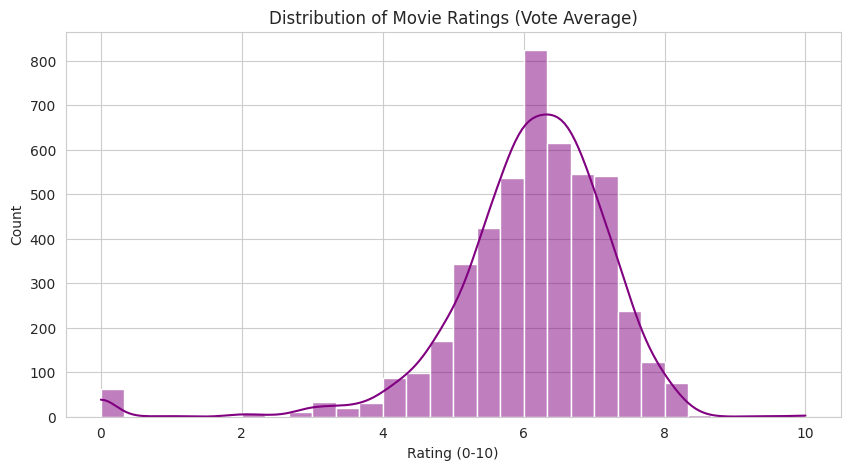

Generating Word Cloud (AI's view of the data)...


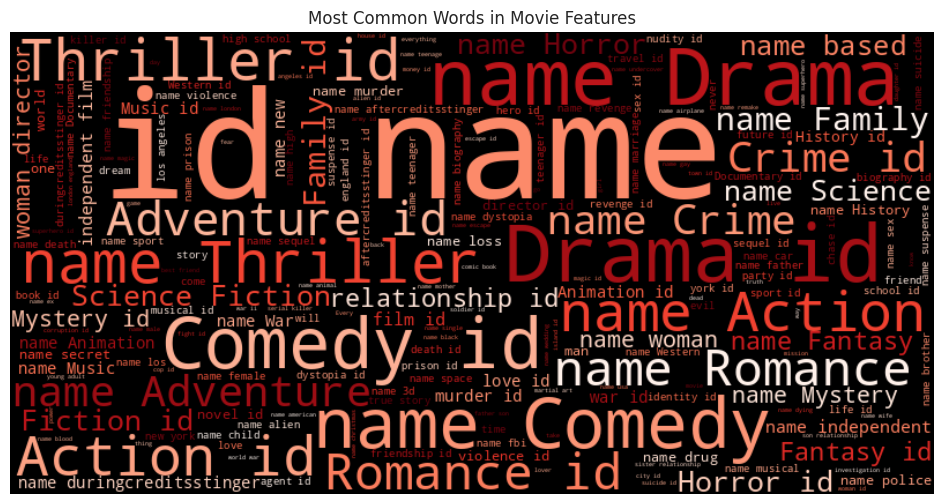

In [11]:
# --- VISUALIZATION 1: Rating Distribution ---
plt.figure(figsize=(10, 5))
sns.histplot(movies_data['vote_average'], bins=30, kde=True, color='purple')
plt.title('Distribution of Movie Ratings (Vote Average)')
plt.xlabel('Rating (0-10)')
plt.ylabel('Count')
plt.show()

# --- VISUALIZATION 2: Word Cloud ---
# This visualizes the most frequent words in our 'combined_features'
print("Generating Word Cloud (AI's view of the data)...")
text_data = " ".join(combined_features.astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(text_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Movie Features')
plt.show()

In [12]:
# 5. Convert Text to Numbers (TF-IDF Vectorization)
print("Vectorizing data (this may take a moment)...")
vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(combined_features)

# 6. Calculate Cosine Similarity
# Calculates the angle (similarity) between every movie pair
print("Calculating Cosine Similarity...")
similarity = cosine_similarity(feature_vectors)

print("✅ Model Trained! The AI is ready to recommend.")

Vectorizing data (this may take a moment)...
Calculating Cosine Similarity...
✅ Model Trained! The AI is ready to recommend.



-------------------------------------------------------
🎬 MOVIE RECOMMENDATION SYSTEM (Visualized) 📊
-------------------------------------------------------

Enter your favorite movie name (or type 'exit'): Batman
🔎 Found match: 'Batman'

🎥 Top 10 Movies like 'Batman':
------------------------------
1. Batman & Robin (Similarity: 0.72)
2. Batman Returns (Similarity: 0.52)
3. The Dark Knight (Similarity: 0.46)
4. Batman Begins (Similarity: 0.43)
5. Superman (Similarity: 0.41)
6. Man of Steel (Similarity: 0.40)
7. The Dark Knight Rises (Similarity: 0.40)
8. Superman Returns (Similarity: 0.39)
9. Superman III (Similarity: 0.39)
10. Batman Forever (Similarity: 0.39)
------------------------------


/tmp/ipython-input-2611805218.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_movies, palette='viridis')


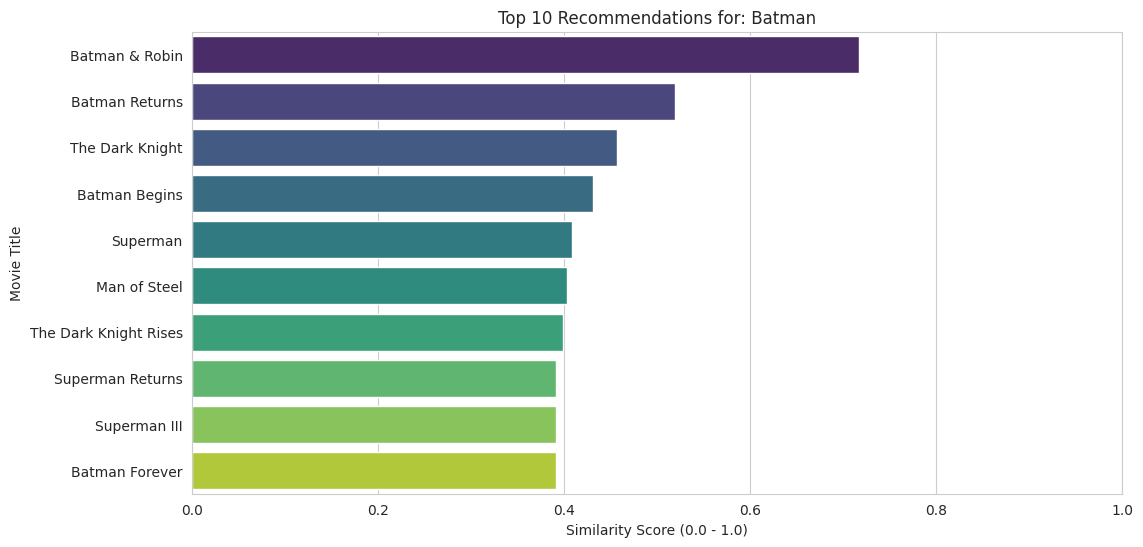

In [ ]:
# 7. Prepare Title List for Searching
list_of_all_titles = movies_data['title'].tolist()

print("\n-------------------------------------------------------")
print("🎬 MOVIE RECOMMENDATION SYSTEM (Visualized) 📊")
print("-------------------------------------------------------")

while True:
    movie_name = input("\nEnter your favorite movie name (or type 'exit'): ")

    if movie_name.lower() == 'exit':
        print("Goodbye! 👋")
        break

    # 1. Handle Typos / Find Close Match
    find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)

    if not find_close_match:
        print("❌ Movie not found! Please check the spelling.")
        continue

    close_match = find_close_match[0]
    print(f"🔎 Found match: '{close_match}'")

    try:
        # 2. Find Index & Get Similarity Scores
        index_of_the_movie = movies_data[movies_data.title == close_match].index[0]
        similarity_score = list(enumerate(similarity[index_of_the_movie]))

        # 3. Sort by Similarity (Highest first)
        sorted_similar_movies = sorted(similarity_score, key=lambda x: x[1], reverse=True)

        # 4. Extract Top 10 Data for Plotting
        top_movies = []
        top_scores = []

        print(f"\n🎥 Top 10 Movies like '{close_match}':")
        print("-" * 30)

        # Skip index 0 (the movie itself) and take next 10
        for i in range(1, 11):
            index, score = sorted_similar_movies[i]
            title = movies_data.loc[index, 'title']

            top_movies.append(title)
            top_scores.append(score)

            print(f"{i}. {title} (Similarity: {score:.2f})")

        print("-" * 30)

        # 5. VISUALIZE THE RESULTS (Bar Chart)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=top_scores, y=top_movies, palette='viridis')
        plt.title(f'Top 10 Recommendations for: {close_match}')
        plt.xlabel('Similarity Score (0.0 - 1.0)')
        plt.ylabel('Movie Title')
        plt.xlim(0, 1) # Scale from 0 to 1
        plt.show()

    except IndexError:
        print("Error: Could not retrieve data for this movie.")